# EECE5644 Assignment 4 - Question 2

## Description:

This notebook implements GMM-based image segmentation using K-fold cross-validation for model order selection. A single image is loaded, preprocessed into 5D feature vectors (row, col, R, G, B), and segmented by clustering pixels based on spatial location and color similarity.

## Table of Contents:
1. Imports & Setup
2. Data
3. GMM
4. Image Analysis

## 1. Setup & Imports

### Description:

This section imports all necessary libraries for the assignment and sets random seeds for reproducibility.

### Table of Contents:
- 1.1 Imports
- 1.2 Random Seed

In [33]:
# @title 1.1 Imports
import requests
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO
from typing import Tuple, List, Dict
from matplotlib.figure import Figure
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [34]:
# @title 1.2 Random Seed
np.random.seed(42)

## 2. Data

### Description:

This section loads a color image from the Berkeley segmentation dataset. Each pixel becomes a 5-dimensional feature vector containing its position (row, column) and colors (R, G, B), normalized to 0-1. Feature distributions are plotted to see what the data looks like before clustering.

### Table of Contents:
- 2.1 Preprocessing Functions
- 2.2 Loading Image
- 2.3 Feature Vector Creation
- 2.4 Analyze Feature Vector

In [35]:
# @title 2.1 Preprocessing Functions

def load_image_from_url(url: str) -> np.ndarray:
  """
  Load image from a URL.
  """
  response = requests.get(url)
  response.raise_for_status()
  img = Image.open(BytesIO(response.content))
  return np.array(img)

def downsample_image(image: np.ndarray, max_dim: int = 200) -> np.ndarray:
  """
  Downsample image if it exceeds maximum dimension.
  """
  height, width = image.shape[:2]
  if max(height, width) > max_dim:
    scale = max_dim / max(height, width)
    new_height = int(height * scale)
    new_width = int(width * scale)
    image = np.array(Image.fromarray(image).resize((new_width, new_height)))
    print(f"Downsampled image to {new_width}x{new_height}")
  return image

Loading image from Berkeley dataset...
Downsampled image to 133x200
Image shape: (200, 133, 3)
Image dtype: uint8
Pixel value range: [0, 254]


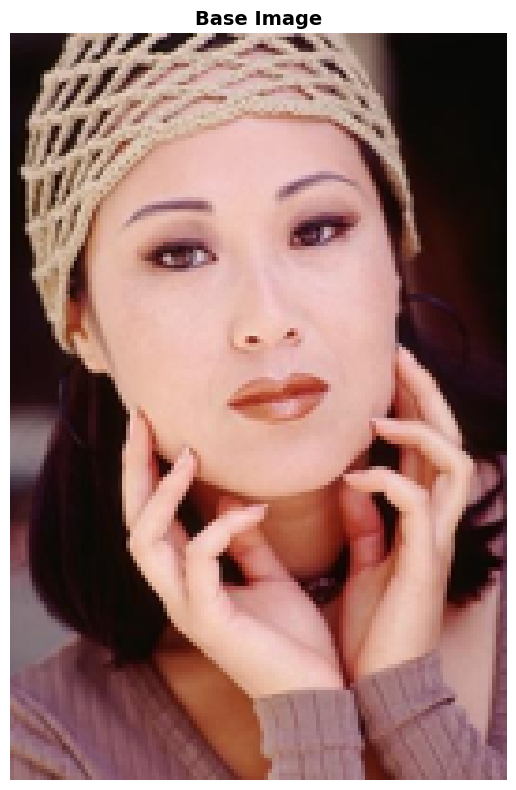

In [36]:
# @title 2.2 Loading Image

# image url (update accordingly)
image_url = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300/html/images/plain/normal/color/302003.jpg"

print(f"Loading image from Berkeley dataset...")
image = load_image_from_url(image_url)

# downsample
image = downsample_image(image, max_dim=200)

# print image stats
print(f"Image shape: {image.shape}")
print(f"Image dtype: {image.dtype}")
print(f"Pixel value range: [{image.min()}, {image.max()}]")

# display image
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image)
ax.set_title('Base Image', fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

In [37]:
# @title 2.3 Feature Vector Creation

def create_feature_vectors(image: np.ndarray) -> np.ndarray:
  """
  Create 5D normalized feature vectors from image pixels.
  """
  height, width = image.shape[:2]

  # Cceate coordinate grids
  rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')

  # extract RGB
  r = image[:, :, 0]
  g = image[:, :, 1]
  b = image[:, :, 2]

  # [row, col, R, G, B]
  features = np.stack([rows, cols, r, g, b], axis=-1)
  features = features.reshape(-1, 5)

  # normalize features to [0, 1]
  features_normalized = np.zeros_like(features, dtype=np.float64)
  for i in range(5):
    min_val = features[:, i].min()
    max_val = features[:, i].max()
    if max_val > min_val:
      features_normalized[:, i] = (features[:, i] - min_val) / (max_val - min_val)
    else:
      features_normalized[:, i] = 0.0

  return features_normalized

# create feature vectors
print("Creating 5D feature vectors...")
features = create_feature_vectors(image)

# print results
print(f"Feature matrix shape: {features.shape}")
print(f"Number of pixels: {features.shape[0]}")
print(f"Feature dimensions: {features.shape[1]}")
print(f"\nFeature statistics:")
print(f"  Min values: {features.min(axis=0)}")
print(f"  Max values: {features.max(axis=0)}")
print(f"  Mean values: {features.mean(axis=0)}")


Creating 5D feature vectors...
Feature matrix shape: (26600, 5)
Number of pixels: 26600
Feature dimensions: 5

Feature statistics:
  Min values: [0. 0. 0. 0. 0.]
  Max values: [1. 1. 1. 1. 1.]
  Mean values: [0.5        0.5        0.57849715 0.51553235 0.49452708]


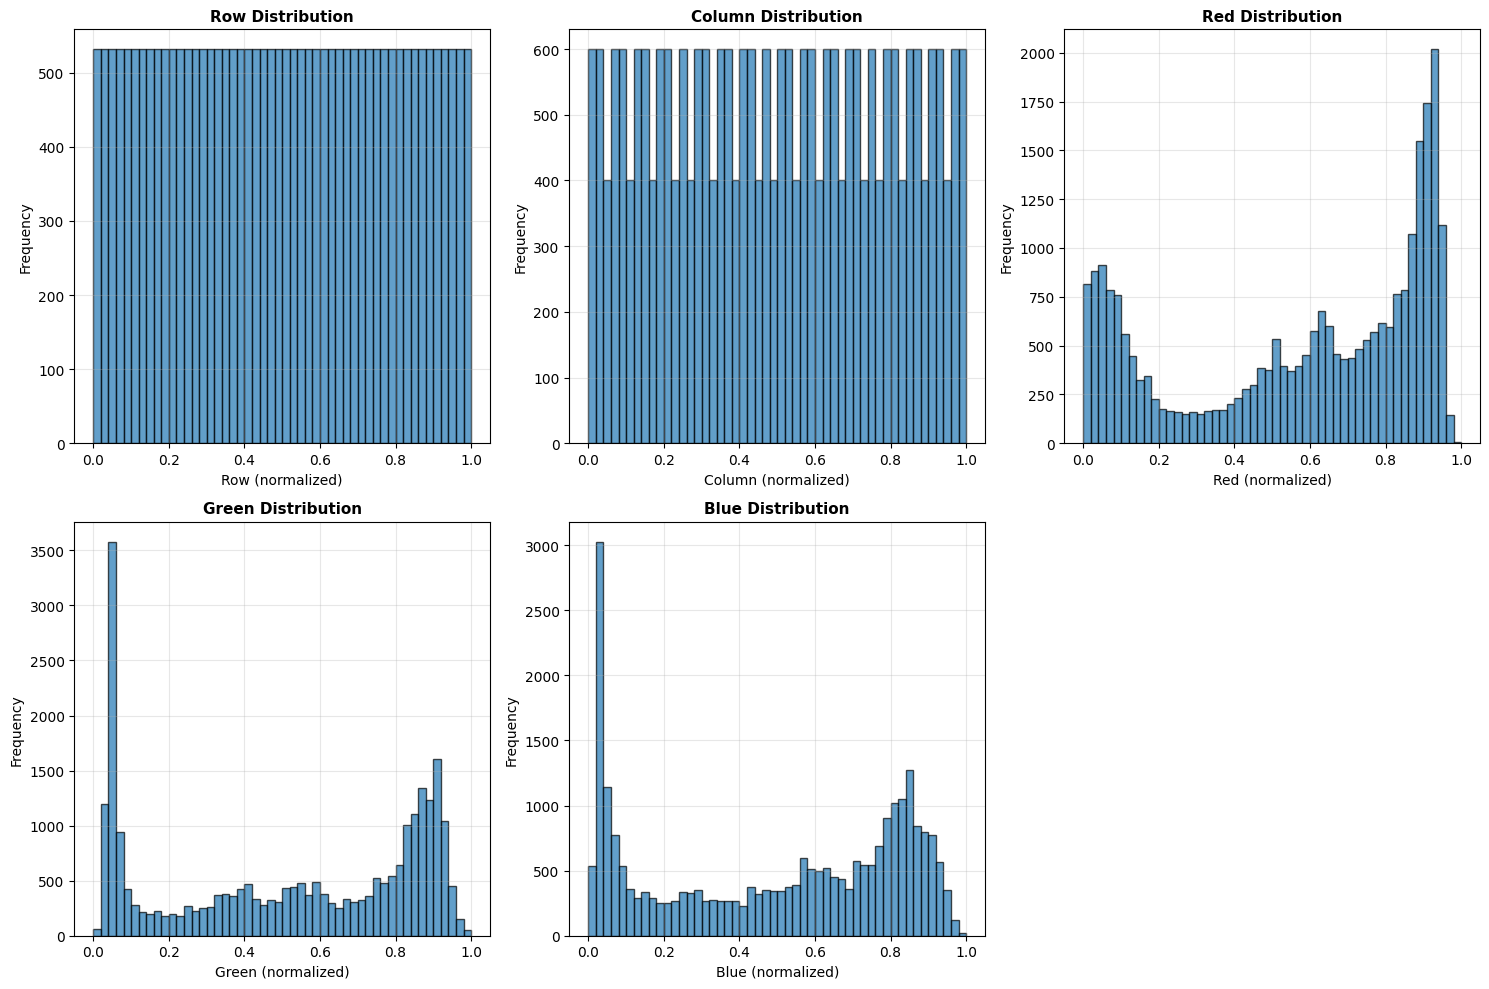

In [38]:
# @title 2.4 Analyze Feature Vector

# setup
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
feature_names = ['Row', 'Column', 'Red', 'Green', 'Blue']

# plot
for i, (ax, name) in enumerate(zip(axes.flat[:5], feature_names)):
  ax.hist(features[:, i], bins=50, alpha=0.7, edgecolor='black')
  ax.set_xlabel(f'{name} (normalized)', fontsize=10)
  ax.set_ylabel('Frequency', fontsize=10)
  ax.set_title(f'{name} Distribution', fontsize=11, fontweight='bold')
  ax.grid(True, alpha=0.3)
axes.flat[5].axis('off')
plt.tight_layout()
plt.show()


## 3. GMM

### Description:

This section uses GMM clustering to segment the image. K-fold cross-validation tests different numbers of components to find the best value. The final GMM is then trained with this optimal number of components.

### Table of Contents:
- 3.1 GMM Cross-Validation Function
- 3.2 Perform GMM Cross-Validation
- 3.3 Visualize GMM Cross-Validation Results
- 3.4 Train Final GMM Model
- 3.5 Analyze Final GMM Model

In [39]:
# @title 3.1 GMM Cross-Validation Function
def gmm_cross_validation(
    features: np.ndarray,
    k_folds: int = 5,
    max_components: int = 10
  ) -> Tuple[int, List[Dict]]:
  """
  K-fold cross-validation for GMM model order selection.
  """
  # hyperparameter space
  n_components_range = range(2, max_components + 1)

  # initialize
  kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
  best_score = -np.inf
  best_n_components = 2
  results: List[Dict] = []

  print("GMM Cross-Validation Progress:")
  for n_components in n_components_range:
    log_likelihoods = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(features)):
      X_train, X_val = features[train_idx], features[val_idx]

      # train & evaluate gmm with current parameters
      gmm = GaussianMixture(
          n_components=n_components,
          covariance_type='full',
          max_iter=100,
          random_state=42
      )
      gmm.fit(X_train)

      # compute average score via log-likelihood
      log_likelihood = gmm.score(X_val)
      log_likelihoods.append(log_likelihood)

    # track results
    avg_log_likelihood = np.mean(log_likelihoods)
    std_log_likelihood = np.std(log_likelihoods)
    results.append({
      'n_components': n_components,
      'log_likelihood': avg_log_likelihood,
      'std': std_log_likelihood
    })

    # logging
    print(f"  {n_components} components: {avg_log_likelihood:.2f} ± {std_log_likelihood:.2f}")

    # update best
    if avg_log_likelihood > best_score:
      best_score = avg_log_likelihood
      best_n_components = n_components

  # print final results
  print(f"\nBest number of components: {best_n_components}")
  print(f"Best validation log-likelihood: {best_score:.2f}")

  return best_n_components, results

In [40]:
# @title 3.2 Perform GMM Cross-Validation
best_n_components, cv_results = gmm_cross_validation(features, k_folds=5, max_components=20)

GMM Cross-Validation Progress:
  2 components: 3.00 ± 0.02
  3 components: 3.64 ± 0.12
  4 components: 4.19 ± 0.03
  5 components: 4.45 ± 0.02
  6 components: 4.75 ± 0.04
  7 components: 4.89 ± 0.03
  8 components: 4.99 ± 0.05
  9 components: 5.05 ± 0.05
  10 components: 5.11 ± 0.05
  11 components: 5.25 ± 0.06
  12 components: 5.33 ± 0.09
  13 components: 5.46 ± 0.05
  14 components: 5.55 ± 0.04
  15 components: 5.66 ± 0.04
  16 components: 5.71 ± 0.05
  17 components: 5.76 ± 0.05
  18 components: 5.78 ± 0.03
  19 components: 5.82 ± 0.03
  20 components: 5.86 ± 0.03

Best number of components: 20
Best validation log-likelihood: 5.86


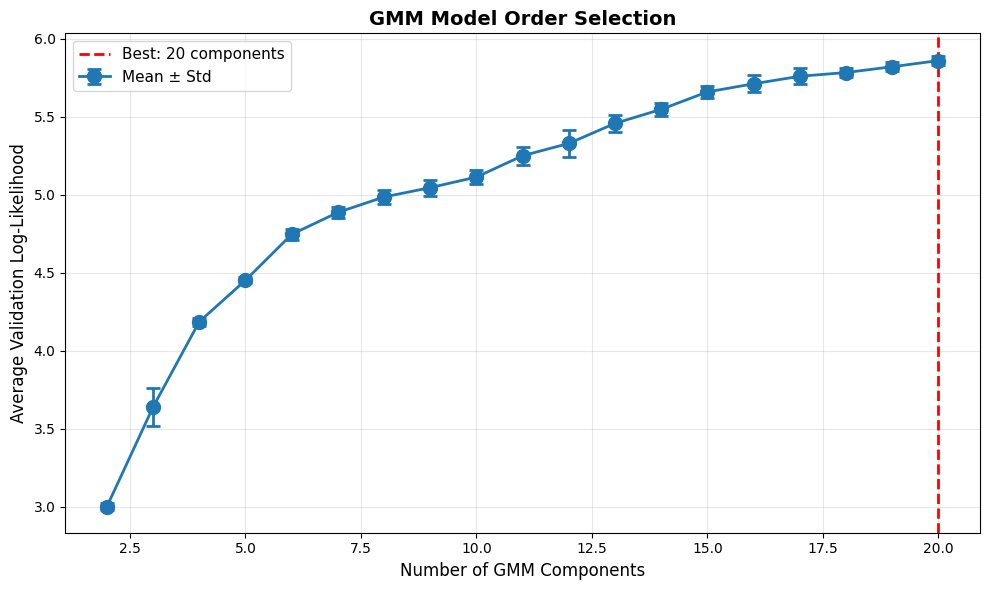

In [41]:
# @title 3.3 Visualize GMM Cross-Validation Results

# setup
n_comps = [r['n_components'] for r in cv_results]
log_liks = [r['log_likelihood'] for r in cv_results]
stds = [r['std'] for r in cv_results]

# plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(n_comps, log_liks, yerr=stds, fmt='o-', linewidth=2, markersize=10,
           capsize=5, capthick=2, label='Mean ± Std')
ax.axvline(best_n_components, color='r', linestyle='--', linewidth=2,
          label=f'Best: {best_n_components} components')
ax.set_xlabel('Number of GMM Components', fontsize=12)
ax.set_ylabel('Average Validation Log-Likelihood', fontsize=12)
ax.set_title('GMM Model Order Selection', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [42]:
# @title 3.4 Train Final GMM Model

# train
print(f"Training final GMM with {best_n_components} components...")
gmm_final = GaussianMixture(
    n_components=best_n_components,
    covariance_type='full',
    max_iter=100,
    random_state=42,
    verbose=0
)
gmm_final.fit(features)

# print results
print(f"GMM converged: {gmm_final.converged_}")
print(f"Number of iterations: {gmm_final.n_iter_}")
print(f"Final log-likelihood: {gmm_final.score(features):.2f}")

Training final GMM with 20 components...
GMM converged: True
Number of iterations: 30
Final log-likelihood: 5.89


In [43]:
# @title 3.5 Analyze Final GMM Model

labels = gmm_final.predict(features)

# print distribution per component
print(f"Predicted {len(np.unique(labels))} unique components")
print(f"Component distribution:")
for i in range(best_n_components):
  count = np.sum(labels == i)
  percentage = count / len(labels) * 100
  print(f"  Component {i}: {count} pixels ({percentage:.2f}%)")

Predicted 20 unique components
Component distribution:
  Component 0: 989 pixels (3.72%)
  Component 1: 1088 pixels (4.09%)
  Component 2: 1819 pixels (6.84%)
  Component 3: 1387 pixels (5.21%)
  Component 4: 1300 pixels (4.89%)
  Component 5: 587 pixels (2.21%)
  Component 6: 1419 pixels (5.33%)
  Component 7: 1041 pixels (3.91%)
  Component 8: 1438 pixels (5.41%)
  Component 9: 1347 pixels (5.06%)
  Component 10: 1108 pixels (4.17%)
  Component 11: 1443 pixels (5.42%)
  Component 12: 1510 pixels (5.68%)
  Component 13: 956 pixels (3.59%)
  Component 14: 1236 pixels (4.65%)
  Component 15: 999 pixels (3.76%)
  Component 16: 3256 pixels (12.24%)
  Component 17: 1374 pixels (5.17%)
  Component 18: 1286 pixels (4.83%)
  Component 19: 1017 pixels (3.82%)


## 4. Image Analysis

### Description:

This section assigns each pixel to its most likely GMM component and visualizes the results. For each component, statistics show how many pixels it contains and what colors they have. Different visualization formats help examine the segmentation quality.

### Table of Contents:
- 4.1 Image Segmentation Function
- 4.2 Segment Image
- 4.3 Component Statistics
- 4.4 Component Plots

In [44]:
# @title 4.1 Image Segmentation Function
def create_segmentation_display(labels: np.ndarray,
                                image_shape: Tuple[int, int]) -> np.ndarray:
  """
  Convert GMM component labels to grayscale image for visualization.
  """
  # setup
  segmentation = labels.reshape(image_shape)

  # normalize labels
  unique_labels = np.unique(labels)
  label_map = {label: i / (len(unique_labels) - 1) * 255
               for i, label in enumerate(unique_labels)}
  segmentation_display = np.vectorize(label_map.get)(segmentation).astype(np.uint8)

  return segmentation_display

Segmentation shape: (200, 133)
Grayscale value range: [0, 255]


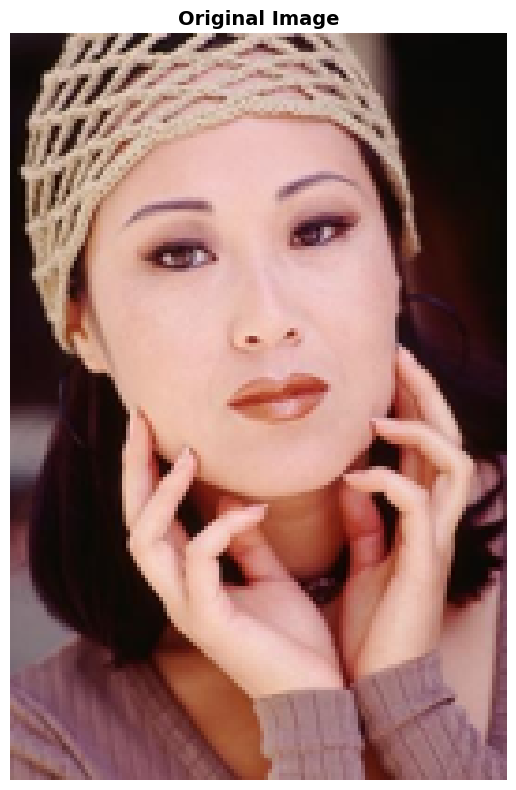

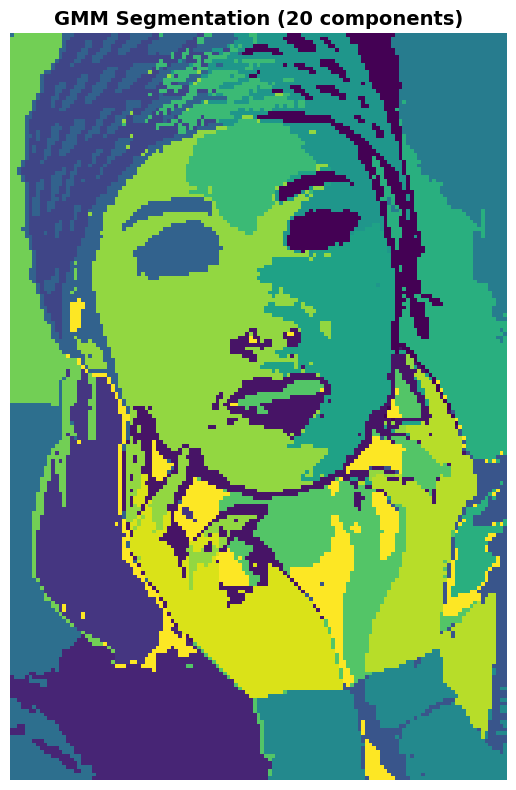

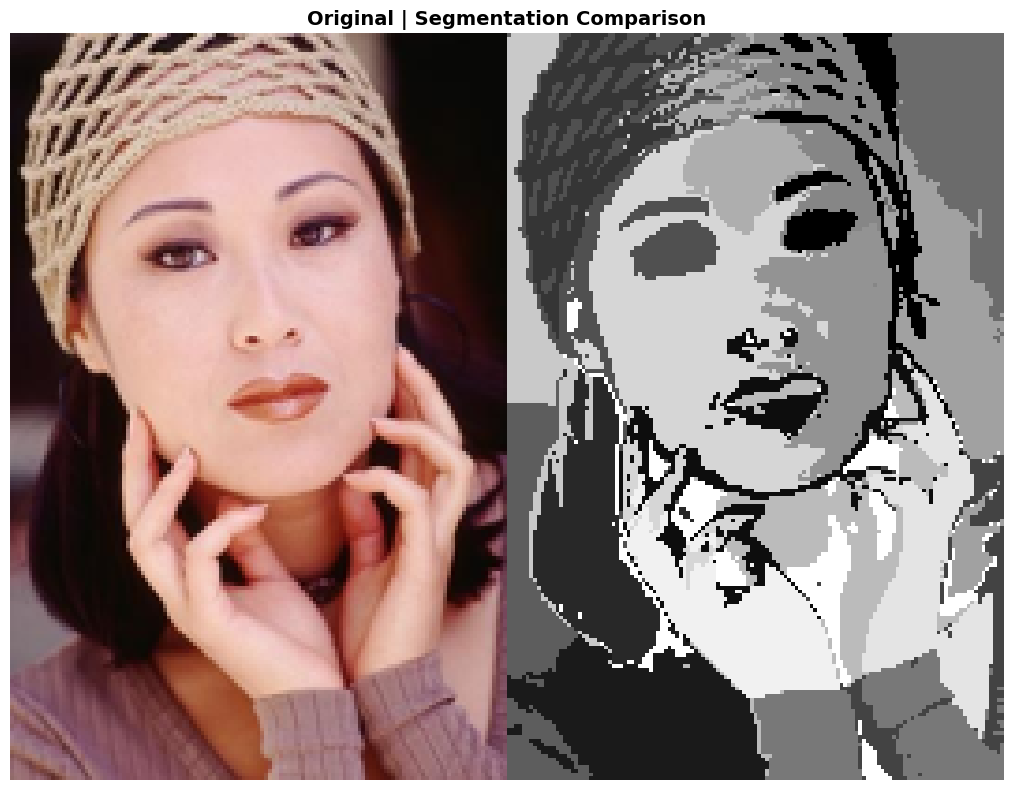

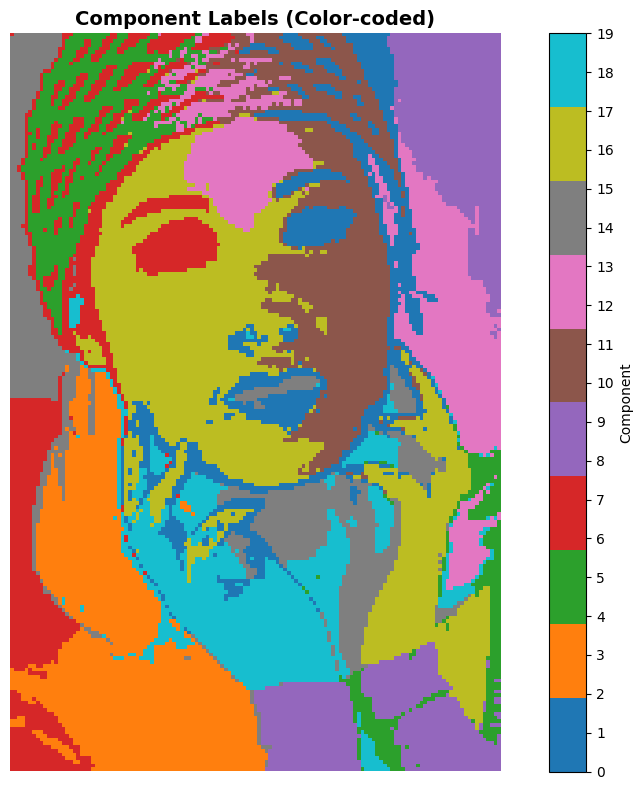

In [45]:
# @title 4.2 Segment Image
height, width = image.shape[:2]
segmentation_display = create_segmentation_display(labels, (height, width))

print(f"Segmentation shape: {segmentation_display.shape}")
print(f"Grayscale value range: [{segmentation_display.min()}, {segmentation_display.max()}]")

# original image
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image)
ax.set_title('Original Image', fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

# segmentation result
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(segmentation_display, cmap='viridis')
ax.set_title(f'GMM Segmentation ({best_n_components} components)', fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

# side-by-side comparison
fig, ax = plt.subplots(figsize=(16, 8))
comparison = np.hstack([image, np.stack([segmentation_display]*3, axis=-1)])
ax.imshow(comparison)
ax.set_title('Original | Segmentation Comparison', fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

# component visualization with different colors
fig, ax = plt.subplots(figsize=(10, 8))
segmentation_rgb = labels.reshape(height, width)
im = ax.imshow(segmentation_rgb, cmap='tab10')
ax.set_title('Component Labels (Color-coded)', fontsize=14, fontweight='bold')
ax.axis('off')
plt.colorbar(im, ax=ax, label='Component', ticks=range(best_n_components))
plt.tight_layout()
plt.show()

In [46]:
# @title 4.3 Component Statistics
print("\nComponent Statistics:")

for i in range(best_n_components):
  component_mask = labels == i
  component_pixels = features[component_mask]

  print(f"\nComponent {i}:")
  print(f"  Number of pixels: {np.sum(component_mask)}")
  print(f"  Percentage: {np.sum(component_mask) / len(labels) * 100:.2f}%")
  print(f"  Mean RGB: [{component_pixels[:, 2].mean():.3f}, "
        f"{component_pixels[:, 3].mean():.3f}, "
        f"{component_pixels[:, 4].mean():.3f}]")


Component Statistics:

Component 0:
  Number of pixels: 989
  Percentage: 3.72%
  Mean RGB: [0.445, 0.360, 0.360]

Component 1:
  Number of pixels: 1088
  Percentage: 4.09%
  Mean RGB: [0.824, 0.682, 0.625]

Component 2:
  Number of pixels: 1819
  Percentage: 6.84%
  Mean RGB: [0.484, 0.325, 0.320]

Component 3:
  Number of pixels: 1387
  Percentage: 5.21%
  Mean RGB: [0.057, 0.044, 0.036]

Component 4:
  Number of pixels: 1300
  Percentage: 4.89%
  Mean RGB: [0.774, 0.807, 0.729]

Component 5:
  Number of pixels: 587
  Percentage: 2.21%
  Mean RGB: [0.461, 0.332, 0.366]

Component 6:
  Number of pixels: 1419
  Percentage: 5.33%
  Mean RGB: [0.535, 0.468, 0.422]

Component 7:
  Number of pixels: 1041
  Percentage: 3.91%
  Mean RGB: [0.445, 0.403, 0.443]

Component 8:
  Number of pixels: 1438
  Percentage: 5.41%
  Mean RGB: [0.022, 0.043, 0.029]

Component 9:
  Number of pixels: 1347
  Percentage: 5.06%
  Mean RGB: [0.621, 0.554, 0.594]

Component 10:
  Number of pixels: 1108
  Percent

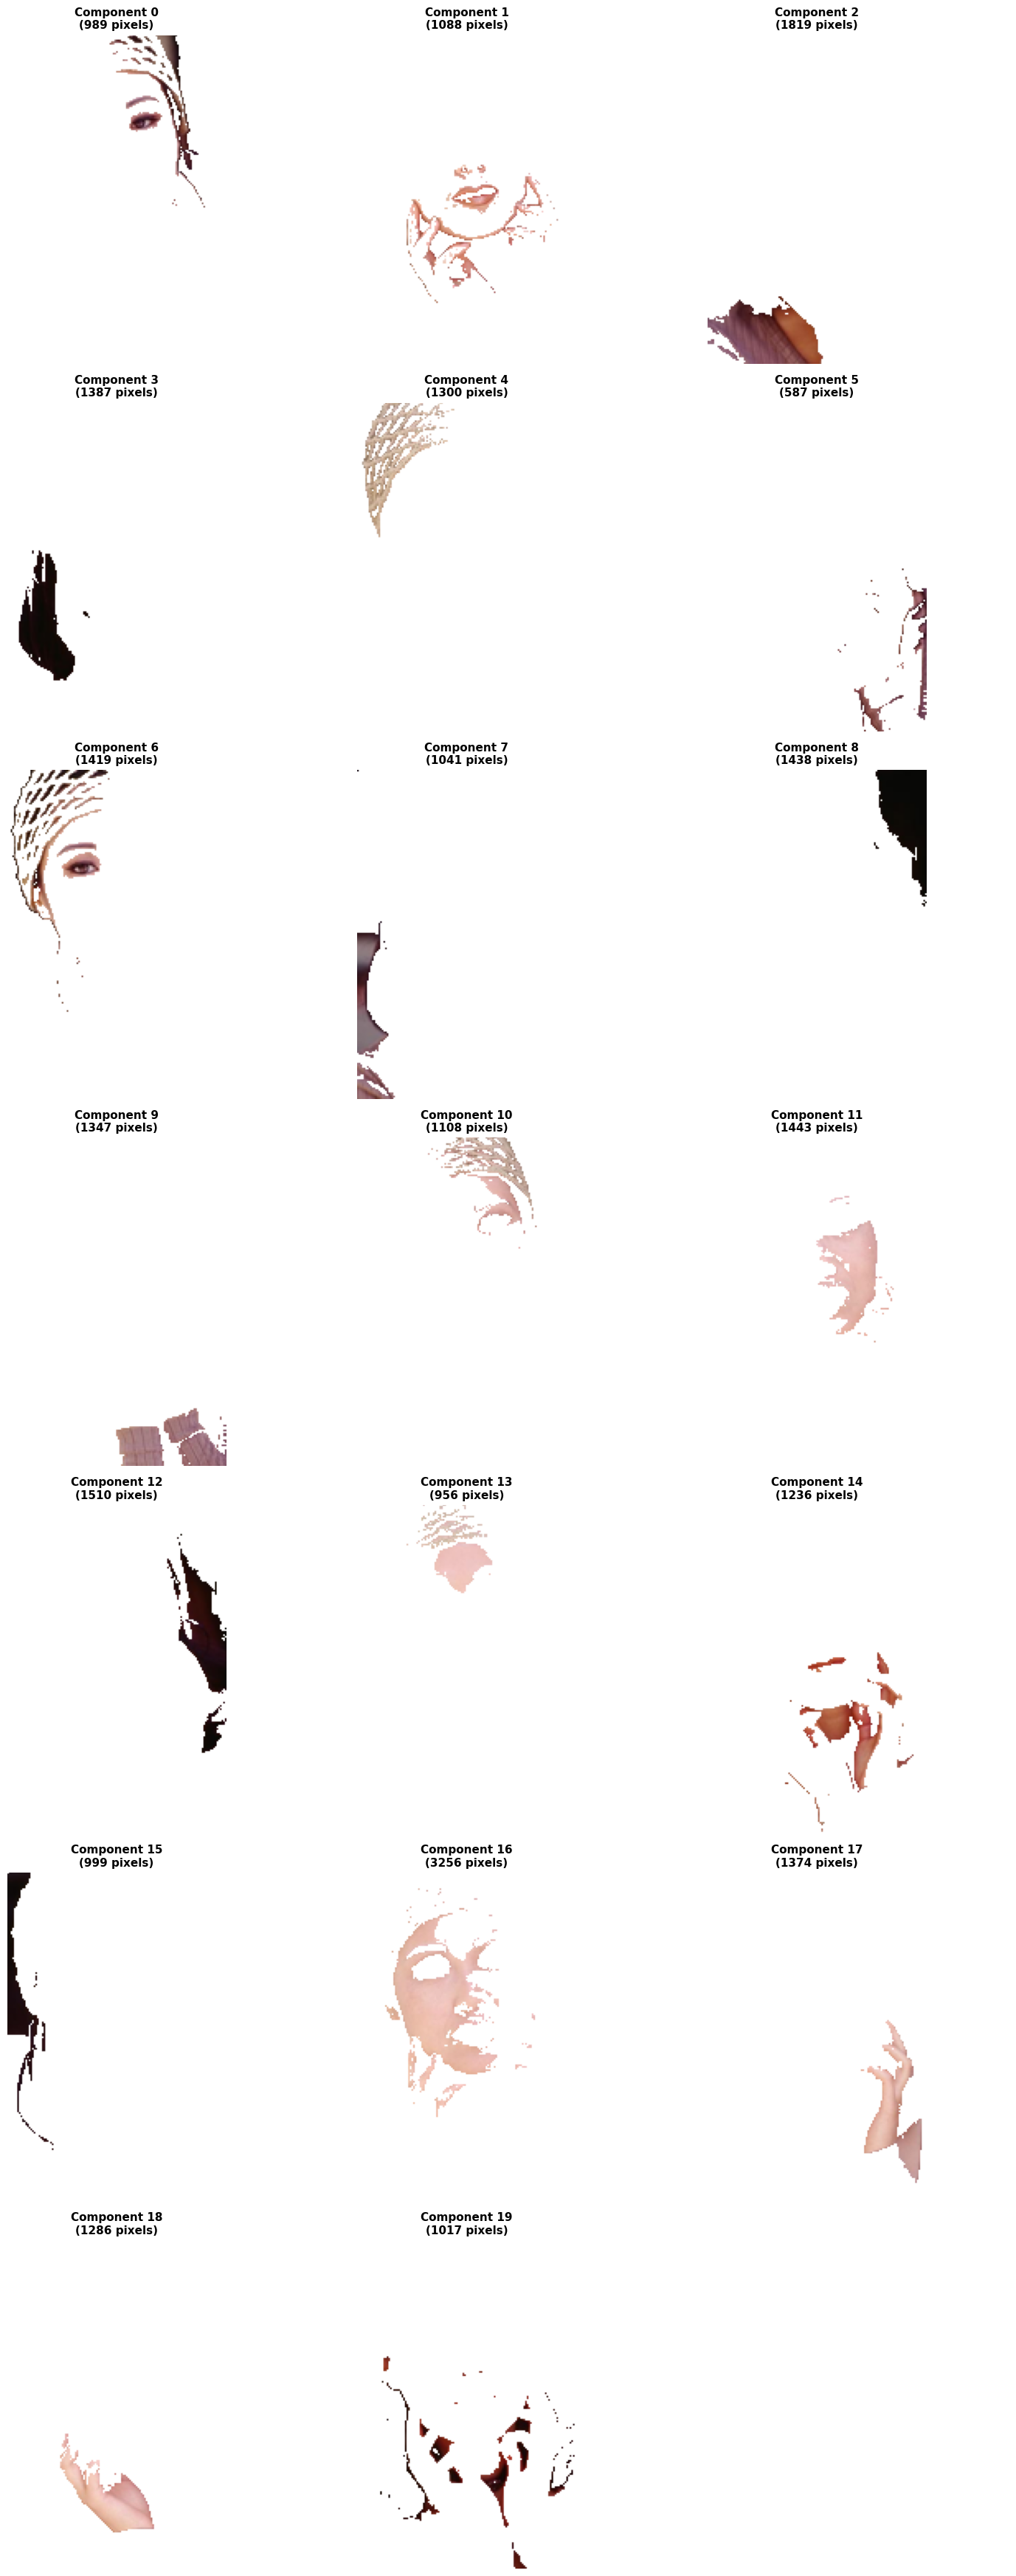

In [47]:
# @title 4.4 Component Plots

# setup
n_rows = (best_n_components + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
axes = axes.flatten()

# plot each component
for i in range(best_n_components):
  component_mask = (labels == i).reshape(height, width)
  component_image = image.copy()
  component_image[~component_mask] = [255, 255, 255]

  axes[i].imshow(component_image)
  axes[i].set_title(f'Component {i}\n({np.sum(component_mask)} pixels)', fontsize=11, fontweight='bold')
  axes[i].axis('off')

# hide unused subplots
for i in range(best_n_components, len(axes)):
  axes[i].axis('off')

plt.tight_layout()
plt.show()